In [1]:
import numpy as np
import pandas as pd
import konlpy
import gensim
import tensorflow as tf
import os

### 1. 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2. 데이터로더 구성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [4]:

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[0]

'<PAD>'

In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence)

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문자 길이 지정
* keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [7]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                     value=word_to_index['<PAD>'],
                                                     padding='pre',
                                                     maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


### 4. 모델 구성 및 validation set 구성

model1: LSTM

In [9]:
vocab_size = 10000    
word_vector_dim = 100  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


model2: 1D CNN

In [15]:
vocab_size = 10000
word_vector_dim = 100

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          44864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          14368     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

model3: Global Pooling + FC layers

In [11]:
vocab_size = 10000
word_vector_dim = 100

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [12]:
X_val = X_train[:10000]
y_val = y_train[:10000]

X_train2 = X_train[10000:]
y_train2 = y_train[10000:]

### 5. 모델 훈련 개시

In [13]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 10
history = model.fit(X_train2,
                   y_train2,
                   epochs = epochs,
                   batch_size=512,
                   validation_data = (X_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 11ms/step - loss: 0.4125 - accuracy: 0.8105 - val_loss: 0.3402 - val_accuracy: 0.8513
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3209 - accuracy: 0.8631 - val_loss: 0.3293 - val_accuracy: 0.8567
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2894 - accuracy: 0.8774 - val_loss: 0.3234 - val_accuracy: 0.8604
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2602 - accuracy: 0.8915 - val_loss: 0.3224 - val_accuracy: 0.8651
Epoch 5/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2335 - accuracy: 0.9043 - val_loss: 0.3372 - val_accuracy: 0.8608
Epoch 6/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2113 - accuracy: 0.9142 - val_loss: 0.3565 - val_accuracy: 0.8555
Epoch 7/10
266/266 [==============================] - 3s 10ms/step - loss: 0.1899 - accuracy: 0.9236 - val_loss: 0.3667 - val_accuracy: 0.8564

In [16]:
model2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 10
history2 = model2.fit(X_train2,
                   y_train2,
                   epochs = epochs,
                   batch_size=512,
                   validation_data = (X_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 3s 8ms/step - loss: 0.4194 - accuracy: 0.7986 - val_loss: 0.3308 - val_accuracy: 0.8565
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2879 - accuracy: 0.8786 - val_loss: 0.3161 - val_accuracy: 0.8654
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2204 - accuracy: 0.9126 - val_loss: 0.3402 - val_accuracy: 0.8628
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1428 - accuracy: 0.9481 - val_loss: 0.3988 - val_accuracy: 0.8543
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.0814 - accuracy: 0.9734 - val_loss: 0.5197 - val_accuracy: 0.8467
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.0501 - accuracy: 0.9846 - val_loss: 0.6053 - val_accuracy: 0.8511
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.0346 - accuracy: 0.9899 - val_loss: 0.7003 - val_accuracy: 0.8462
Epoch 

In [17]:
model3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 10
history3 = model3.fit(X_train2,
                   y_train2,
                   epochs = epochs,
                   batch_size=512,
                   validation_data = (X_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 4ms/step - loss: 0.4803 - accuracy: 0.8007 - val_loss: 0.3468 - val_accuracy: 0.8483
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3192 - accuracy: 0.8641 - val_loss: 0.3289 - val_accuracy: 0.8577
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2768 - accuracy: 0.8859 - val_loss: 0.3313 - val_accuracy: 0.8584
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2426 - accuracy: 0.9024 - val_loss: 0.3434 - val_accuracy: 0.8566
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2099 - accuracy: 0.9182 - val_loss: 0.3606 - val_accuracy: 0.8531
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1777 - accuracy: 0.9342 - val_loss: 0.3857 - val_accuracy: 0.8515
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1460 - accuracy: 0.9484 - val_loss: 0.4159 - val_accuracy: 0.8458
Epoch 

In [18]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4832 - accuracy: 0.8453
[0.4831547737121582, 0.8453323245048523]


In [19]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8879 - accuracy: 0.8386
[0.8878782987594604, 0.8386394381523132]


In [20]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5454 - accuracy: 0.8367
[0.5453781485557556, 0.8367475867271423]


LSTM은 84.5%, 1D CNN은 83.8%, GlobalPooling은 83.6% 정확도를 보였습니다.

### 6. Loss, Accuracy 그래프 시각화

In [21]:
import matplotlib.pyplot as plt

def draw_graph(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()   

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

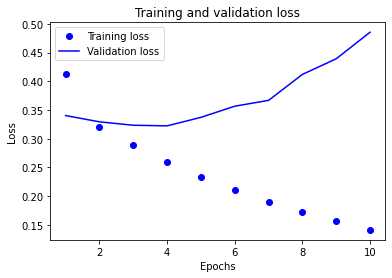

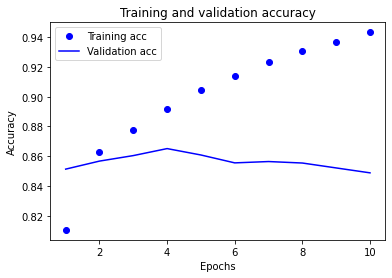

In [22]:
draw_graph(history.history)

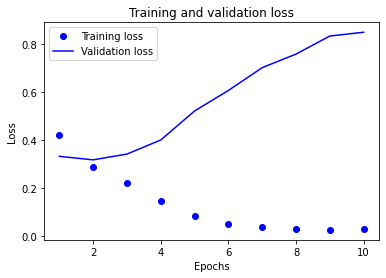

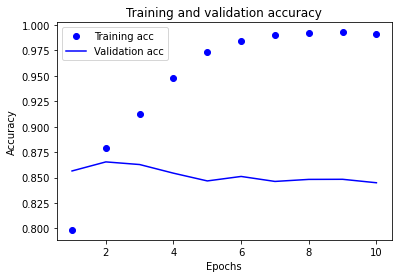

In [23]:
draw_graph(history2.history)

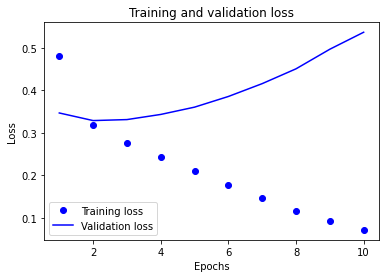

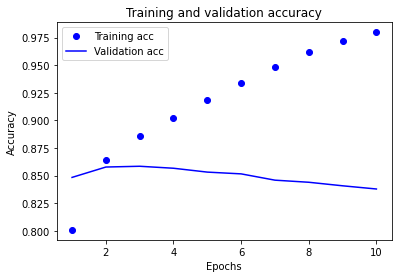

In [24]:
draw_graph(history3.history)

임베딩 사이즈를 100으로 높게 주니 오버피팅이 앞쪽 에폭에서 일어났습니다. LSTM은 1D CNN, GlobalPooling 보다 성능이 높고 오버피팅이 늦게 일어났습니다.

### 7. 학습된 Embedding 레이어 분석

gensim의 유사단어 찾기를 활용!

In [25]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
print(vocab_size)

(10000, 100)
10000


In [26]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_pj.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.09185345,  0.03691968, -0.04529316,  0.03950887,  0.03467666,
        0.04049136, -0.02986033,  0.09544301, -0.07512377,  0.00303418,
       -0.01008261,  0.00251129,  0.02083109,  0.05822121,  0.01890342,
       -0.06743925,  0.00339336, -0.02349008, -0.01630742, -0.03749125,
        0.02755979, -0.07387788,  0.0526343 , -0.03629579, -0.03784126,
       -0.10720918, -0.01914161, -0.1080402 ,  0.0412539 ,  0.07322812,
        0.00133606,  0.02544018, -0.08848   , -0.00263236, -0.10441199,
       -0.04072491, -0.07988805,  0.0761589 ,  0.03245803, -0.05052232,
        0.00057977, -0.06686097,  0.01645643,  0.01969675, -0.09570114,
       -0.03002417, -0.05710001,  0.09015498,  0.03922992, -0.00896454,
       -0.04840633,  0.00328194, -0.06541374,  0.01209556,  0.08273295,
        0.09953339, -0.04111178, -0.111981  ,  0.03263074, -0.02919754,
       -0.04862733, -0.01489534, -0.02804942,  0.06987467, -0.03101553,
        0.05006673,  0.05870665,  0.09396017,  0.03454487, -0.01

In [28]:
word_vectors.similar_by_word("스릴")

[('이영화', 0.73896723985672),
 ('90', 0.6859689950942993),
 ('매우', 0.677191436290741),
 ('가혹', 0.6720279455184937),
 ('철', 0.6609389781951904),
 ('독창', 0.6535924077033997),
 ('댐', 0.6535642743110657),
 ('이준', 0.6434230208396912),
 ('꾸준히', 0.6430028676986694),
 ('쨋', 0.6360434293746948)]

트레이닝된 임베딩 레이어에서 '스릴'이라는 단어와 유사도가 높은 단어들을 출력했습니다. 유사하다고 보기 힘든 단어들이 나옵니다.

### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path2 = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path2)
vector = word_vectors.wv['끝']

In [30]:
word_vectors.wv.similar_by_word("스릴")

[('박진감', 0.6611842513084412),
 ('코스튬', 0.6496943235397339),
 ('큐어', 0.6490173935890198),
 ('인간미', 0.6467803716659546),
 ('드라이빙', 0.6459862589836121),
 ('슬로우', 0.6364979147911072),
 ('색다른', 0.6349014043807983),
 ('유머', 0.6346139311790466),
 ('크레이지', 0.630340039730072),
 ('박력', 0.6204926371574402)]

한국어 Word2Vec에서 '스릴'과 유사도가 높은 단어를 출력했습니다. '박진감', '드라이빙', '크레이지', '박력' 같이 사람이 보기에도 유사한 단어들이 나옵니다.

In [32]:
vocab_size = 10000    
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
word2vec = word_vectors.wv

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 100   

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(X_train2,
                    y_train2,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 5s 12ms/step - loss: 0.4679 - accuracy: 0.7741 - val_loss: 0.3781 - val_accuracy: 0.8325
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3419 - accuracy: 0.8507 - val_loss: 0.3290 - val_accuracy: 0.8538
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2983 - accuracy: 0.8735 - val_loss: 0.3217 - val_accuracy: 0.8591
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2687 - accuracy: 0.8876 - val_loss: 0.3088 - val_accuracy: 0.8688
Epoch 5/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2461 - accuracy: 0.8990 - val_loss: 0.3198 - val_accuracy: 0.8624
Epoch 6/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2252 - accuracy: 0.9087 - val_loss: 0.3235 - val_accuracy: 0.8635
Epoch 7/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2049 - accuracy: 0.9188 - val_loss: 0.3272 - val_accuracy: 0.8674

In [43]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3967 - accuracy: 0.8573
[0.3967230021953583, 0.857293963432312]


한국어 Word2Vec을 활용한 LSTM으로 목표 성능인 정확도 85%를 달성했습니다.

### 회고

한국어 Word2Vec의 임베딩 사이즈를 작게 맞추는 방법을 찾아보다가 잘 안나와서 다른 실험들의 임베딩 사이즈를 늘렸는데 이 부분이 아쉽게 느껴집니다. 큰 임베딩 사이즈를 가진 단어사전을 작은 임베딩사이즈로 압축하는 것을 마저 해보고싶습니다.  